In [1]:
from projection.project import ImageProjection, flip_north_south
import matplotlib.pyplot as plt
import numpy as np

Load the image and the timestamp so that we can calculate ephemerides

In [2]:
projector = ImageProjection('2019-02-02-1007_1-RGBdp.jpg', '2019-02-02T10:07:00')

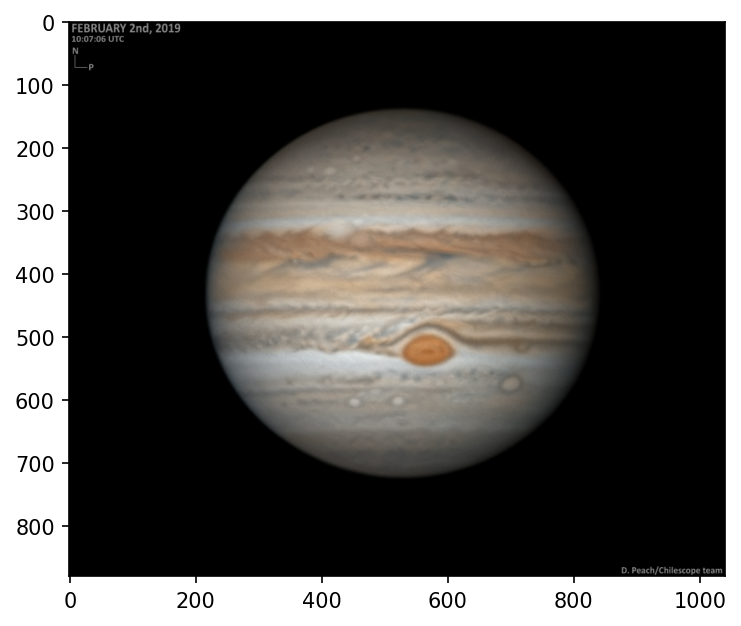

In [3]:
fig, ax = plt.subplots(1, 1, dpi=150)
ax.imshow(projector.data)
plt.show()

Let's get the contour for the limb so that we can fit the WCS. If the contour is not well defined, then we can modify the fitting parameters. Try changing the `gamma` (which is the contrast-stretching parameter, where a lower gamma will include more darker pixels) and the `threshold` (which is the pixel value to count as the limb, so a higher threshold will give a tighter fit to the ellipse)

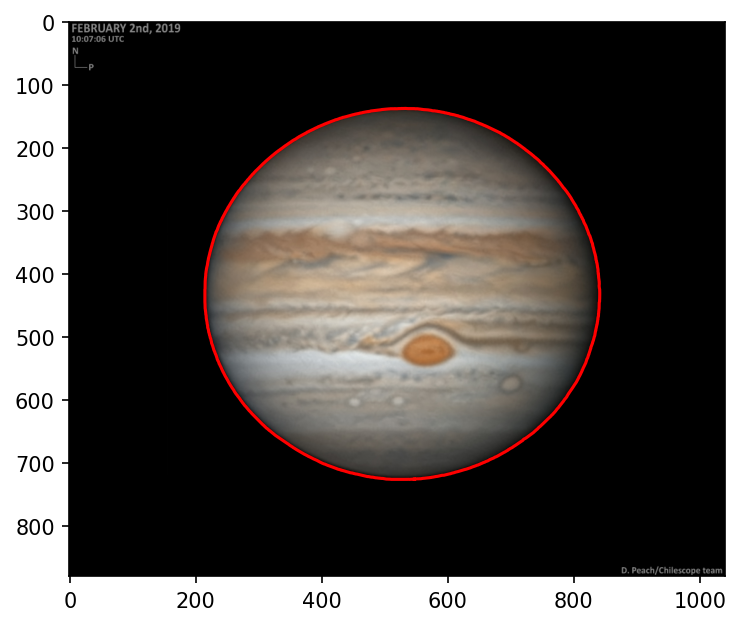

In [4]:
contour = projector.detect_limb(gamma=0.1, threshold=0.7)

fig, ax = plt.subplots(1, 1, dpi=150)
ax.imshow(projector.data)
ax.plot(*contour.T, 'r-')
plt.show()

Fit the WCS based on the detected limb, which returns an `astropy.wcs.WCS` object

In [5]:
wcs = projector.fit_limb_from_contour(contour)

In [6]:
# run this if you think the fitted ellipse is upside down (north-pole at south and vice-versa)
wcs = flip_north_south(wcs)

In [7]:
# get a list of points for the limb so we can plot it out
points = wcs.wcs_world2pix(np.degrees(projector.limbRADec), 0)

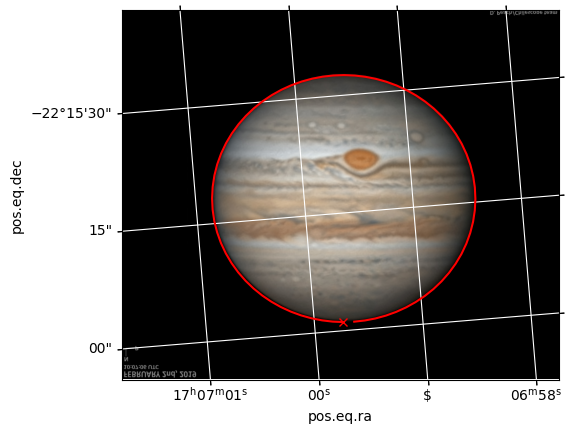

In [8]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': wcs})
ax.imshow(projector.data, origin='lower')
ax.plot(*points.T, 'r-')

# red cross is the north pole
ax.plot(*points[0], 'rx')
ax.grid(color='white', ls='solid')

In [9]:
# apply the wcs to the projector object if it looks good so we can start projecting
projector.wcs = wcs

In [10]:
lonlat = projector.project_to_lonlat()

100%|████████████████████████████████████████████████████████████████████████| 915200/915200 [06:52<00:00, 2219.22it/s]


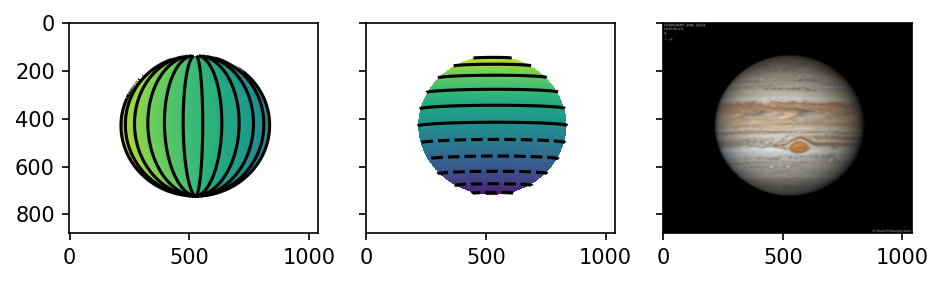

In [11]:
fig, axs = plt.subplots(1, 3, dpi=150, sharex=True, sharey=True)

axs[0].imshow(projector.lonlat[:, :, 0])
axs[0].contour(projector.lonlat[:, :, 0], np.arange(0, 360, 15), colors='k')
axs[1].imshow(projector.lonlat[:, :, 1])
axs[1].contour(projector.lonlat[:, :, 1], np.arange(-90, 90, 15), colors='k')
axs[2].imshow(projector.data)
plt.tight_layout()
plt.show()

In [12]:
from scipy.interpolate import griddata

def plot_map(lon, lat, img, pixres=0.1):
    '''
        project the image onto a lat/lon grid
    '''
    gridlat = np.arange(-90., 90., pixres)
    gridlon = np.arange(0., 360., pixres)

    LAT, LON = np.meshgrid(gridlat, gridlon)

    lon_f = lon.flatten()
    lat_f = lat.flatten()
    r_f = img[:, :, 0].flatten()
    g_f = img[:, :, 1].flatten()
    b_f = img[:, :, 2].flatten()

    mask = np.where(np.isfinite(lon_f) & np.isfinite(lat_f))[0]
    r = r_f[mask]
    g = g_f[mask]
    b = b_f[mask]
    lats = lat_f[mask]
    lons = lon_f[mask]

    # convert to east positive
    R = griddata((lons, lats), r, (LON, LAT), method='cubic').T
    G = griddata((lons, lats), g, (LON, LAT), method='cubic').T
    B = griddata((lons, lats), b, (LON, LAT), method='cubic').T

    IMG = np.stack([R, G, B], axis=2)
    IMG[np.isnan(IMG)] = 0.
    IMG[IMG < 0.] = 0.

    return IMG

In [13]:
image = plot_map(projector.lonlat[:, :, 0], projector.lonlat[:, :, 1], projector.data)

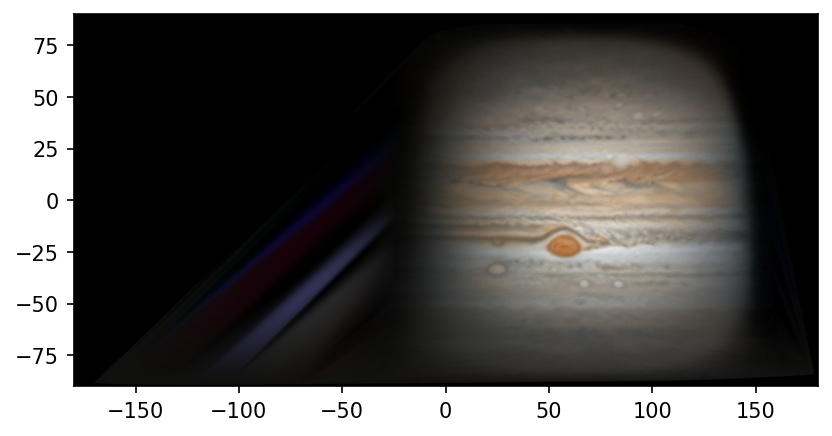

In [14]:
fig, ax = plt.subplots(1, 1, dpi=150)
ax.imshow(image / 255, extent=(-180, 180, -90, 90), origin='lower')
plt.show()

In [15]:
plt.imsave('map.png', image / 255)

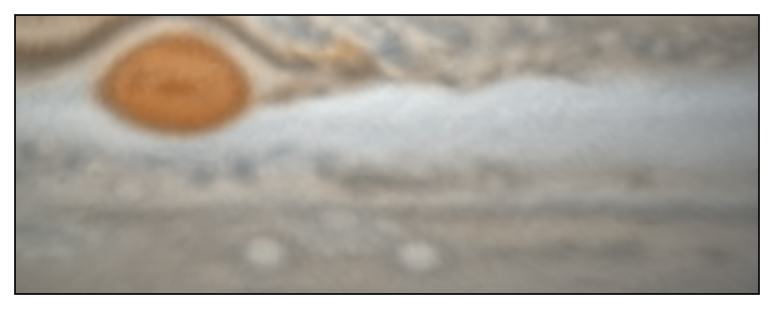

In [16]:
import cartopy.crs as ccrs

globe = ccrs.Globe(semimajor_axis=71492e3, semiminor_axis=66854e3)
pc = ccrs.PlateCarree(globe=globe)
laea = ccrs.LambertAzimuthalEqualArea(central_latitude=-20, central_longitude=90, globe=globe)

fig, ax = plt.subplots(1, 1, dpi=150, subplot_kw={'projection': pc})
ax.imshow(image / 255, extent=(-180, 180, 90, -90), transform=pc)
# ax.set_extent([-45000e3, 45000e3, -20000e3, 20000e3], crs=laea)
ax.set_extent([40, 120, -45, -15], crs=pc)
plt.show()